In [8]:
import pandas as pd
import yfinance as yf

# Using Python 3.11.1

file1 = 'Download Data - STOCK_US_XNAS_ADBE.csv'
file2 = 'Download Data - STOCK_US_XNYS_ORCL.csv'

adbe = yf.download('ADBE', period = '3y')['Close']
orcl = yf.download('ORCL', period = '3y')['Close']

# Spread
spread = adbe - orcl

# ADF Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(spread.dropna())

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADF Statistic: -1.319142678062939
p-value: 0.6203696496365033
Critical Values:
   1%, -3.439052522969989
Critical Values:
   5%, -2.8653808299915013
Critical Values:
   10%, -2.5688152592363274


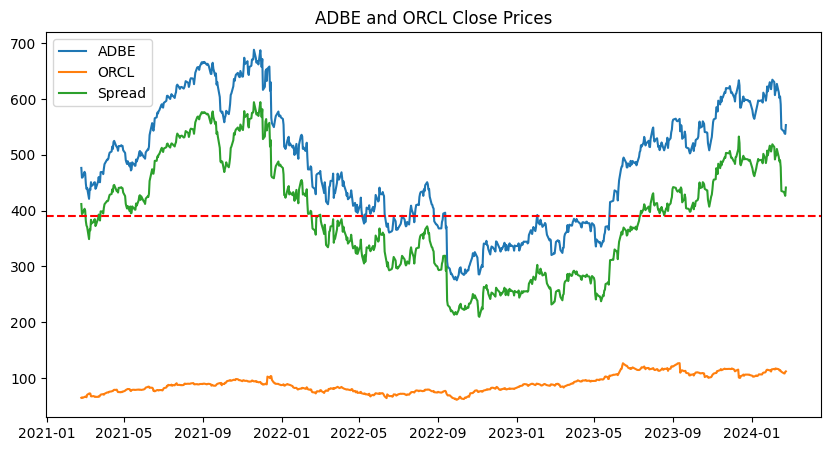

In [11]:
import matplotlib.pyplot as plt

# Plot the close data
plt.figure(figsize=(10, 5))

plt.plot(adbe, label='ADBE')
plt.plot(orcl, label='ORCL')

# Plot the spread data
plt.plot(spread, label='Spread')
plt.axhline(spread.mean(), color='red', linestyle='--')
plt.legend()
plt.title('ADBE and ORCL Close Prices')
plt.show()

In [12]:
from scipy.stats import spearmanr

# Calculate the daily returns
adbe_returns = adbe.pct_change().dropna()
orcl_returns = orcl.pct_change().dropna()

# Compute Spearman Rank Correlation Coefficient
correlation, pvalue = spearmanr(adbe_returns, orcl_returns)

# Print the results
print('Correlation:', correlation)
print('p-value:', pvalue)

Correlation: 0.5197955975910156
p-value: 2.0595298645994695e-53


In [13]:
# Bollinger Band Parameters:
rolling_window = 8     # This is used for determining how many days ahead to use to calculate the rolling mean
rolling_mean = (spread.rolling(window=rolling_window).mean()).dropna()
rolling_std = (spread.rolling(window=rolling_window).std()).dropna()
upper_band = rolling_mean + (rolling_std * 0.8)
lower_band = rolling_mean - (rolling_std * 0.8)

In [14]:
# Capital to allocate to each trade in the pairs trade:
money_per_trade = 50000

# Convert capital to shares:
adbe_share_quant = money_per_trade/adbe
orcl_share_quant = money_per_trade/orcl

daily_returns = []
trade_log = []
position_open = False
position_type = None

for date, current_spread in spread.items():
    if date not in adbe.index or date not in upper_band.index:
        continue
    adbe_price = adbe.get(date, None)
    orcl_price = orcl.get(date, None)
    lower_band_value = lower_band[date]
    upper_band_value = upper_band[date]
    mean_value = rolling_mean[date]
    adbe_shares = adbe_share_quant.get(date, None)
    orcl_shares = orcl_share_quant.get(date, None)
    if current_spread < lower_band_value and not position_open:
        # Open a pairs trade position (short HMC, long HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'lower',
            'ADBE_Shares': adbe_shares,
            'ORCL_Shares': orcl_shares,
            'ADBE_Price': adbe_price,
            'ORCL_Price': orcl_price
        })
        position_open = True
        position_type = 'lower'
        
    elif current_spread > upper_band_value and not position_open:
        # Open a different pairs trade position (long HMC, short HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'upper',
            'ADBE_Shares': adbe_shares,
            'ORCL_Shares': orcl_shares,
            'ADBE_Price': adbe_price,
            'ORCL_Price': orcl_price
        })
        position_open = True
        position_type = 'upper'
    
    elif current_spread > mean_value and position_open and position_type == 'lower':
        # Close position opened at lower band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'lower',
            'ADBE_Shares': adbe_shares,
            'ORCL_Shares': orcl_shares,
            'ADBE_Price': adbe_price,
            'ORCL_Price': orcl_price
        })
        position_open = False
        
    elif current_spread < mean_value and position_open and position_type == 'upper':
        # Close position opened at upper band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'upper',
            'ADBE_Shares': adbe_shares,
            'ORCL_Shares': orcl_shares,
            'ADBE_Price': adbe_price,
            'ORCL_Price': orcl_price
        })
        position_open = False

# Save the trade log DataFrame to a csv file for a visual sanity check:
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('tradelog.csv')

In [15]:
# Iterate through rows in our trade log DataFrame and calcule the pnl:
total_return = 0
open_position = None
close_position_dates = []
close_position_returns = []
for index, trade in trade_log_df.iterrows():
    if trade['Action'] == 'Open Position':
        open_position = trade
    elif trade['Action'] == 'Close Position' and open_position is not None:
        close_position = trade
        close_position_dates.append(trade['Date'])
        if open_position['Type'] == 'lower':
            hmc_profit_loss = (open_position['ADBE_Price'] - trade['ADBE_Price']) * (open_position['ADBE_Price'])
            hymtf_profit_loss = (trade['ORCL_Price'] - open_position['ORCL_Price']) * (open_position['ORCL_Shares'])
        elif open_position['Type'] == 'upper':
            hmc_profit_loss = (trade['ADBE_Price'] - open_position['ADBE_Price']) * (open_position['ADBE_Price'])
            hymtf_profit_loss = (open_position['ORCL_Price'] - trade['ORCL_Price']) * (open_position['ORCL_Shares'])

        total_profit_loss = hmc_profit_loss + hymtf_profit_loss
        total_return += total_profit_loss
        close_position_returns.append(total_profit_loss)

profit_loss_df = pd.DataFrame(close_position_returns, index=close_position_dates, columns=['Profit/Loss'])
profit_loss_df.to_csv('returns.csv')

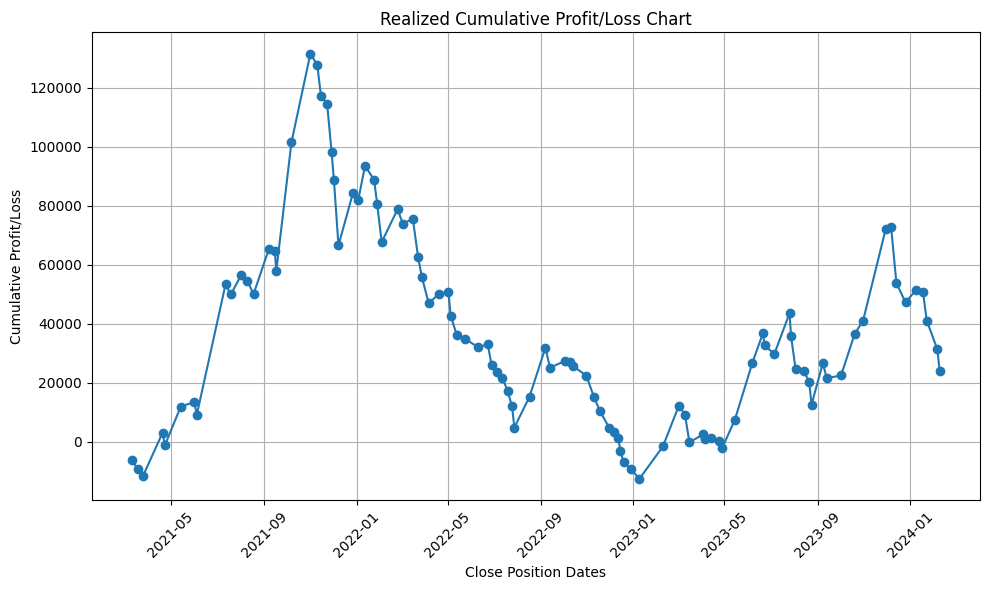

In [16]:
# Import the packages needed for this task:
import matplotlib.pyplot as plt

# Calculate the cumulative profit and loss:
profit_loss_df['Cumulative PnL'] = profit_loss_df['Profit/Loss'].cumsum()

# Plot:
plt.figure(figsize=(10, 6))
plt.plot(profit_loss_df.index, profit_loss_df['Cumulative PnL'], marker='o', linestyle='-')
plt.title('Realized Cumulative Profit/Loss Chart')
plt.xlabel('Close Position Dates')
plt.ylabel('Cumulative Profit/Loss')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()